In [1]:
import pandas as pd
import jax.numpy as jnp
from jax.nn import softmax
from jax import vmap
import evofr as ef

In [2]:
# Getting data
raw_seq = pd.read_csv("../../rt-from-frequency-dynamics/data/omicron-us-split/omicron-us-split_location-variant-sequence-counts.tsv", sep="\t")
locations = ["Washington", "New York"]
raw_seq = raw_seq[raw_seq["location"].isin(locations)]
variant_frequencies = ef.HierFrequencies(raw_seq, group="location")
n_groups = len(locations)

In [3]:
# Defining model
mlr = ef.models.HierMLR(tau=4.2)

In [4]:
# Defining inference method
#nuts = ef.InferNUTS(num_warmup=1000, num_samples=100)
svi_MAP = ef.InferMAP(iters=10_000, lr=0.01)
#svi_FullRank = ef.InferFullRank(iters=10_000, lr=0.01, num_samples=100)

In [5]:
# Fitting model
#posterior = nuts.fit(mlr, variant_frequencies)
posterior = svi_MAP.fit(mlr, variant_frequencies)
#posterior = svi_FullRank.fit(mlr, variant_frequencies)

## Plotting results

In [6]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms

font = {'family' : 'Helvetica',
        'weight' : 'light',
        'size'   : 32}

matplotlib.rc('font', **font)

In [7]:
ps = [0.95, 0.8, 0.5]
alphas = [0.2, 0.4, 0.6]


v_colors = ["#56e39f", "#89CFF0", "#C70039",  "#5567aa", "#c5d46f", "#aa34a4", "#808080"]

v_names = ['Delta', 
           'Omicron 21L', 
           'Omicron 21K', 
           'Omicron 22A', 
           'Omicron 22B', 
           'Omicron 22C', 
           'other']
color_map = {v : c for c, v in zip(v_colors, v_names)}

In [8]:
def posterior_frequency_grouped(dataset, X):
    """
    Use posterior beta to get posterior frequenicies based on matrix X.
    """
    beta = jnp.array(dataset["beta"])
    dot_by_group = vmap(jnp.dot, in_axes=(-1, -1), out_axes=-1)
    dbg_by_sample = vmap(dot_by_group, in_axes=(None, 0)) # Loop over samples
    logits = dbg_by_sample(X, beta)  # Logit frequencies by variant
    return softmax(logits, axis=-2)

In [14]:
last_T = len(variant_frequencies.dates) # Get end of fitting period
forecast_L = 14 # How far ahead to forecast

# Creating feature matrices
X = mlr.make_ols_feature(start=0, stop=last_T, n_groups=n_groups) 
X_forecast = mlr.make_ols_feature(start=last_T, stop=last_T + forecast_L, n_groups=n_groups)

# Computing posterior frequencies
freq = posterior.samples["freq"]
freq_forecast = posterior_frequency_grouped(posterior.samples, X_forecast)

In [15]:
freq.shape

(1, 138, 7, 2)

In [16]:
freq_forecast.shape

(1, 14, 7, 2)

In [17]:
def plot_MLR_frequencies(ax, t, freq, ps, alphas, colors):
    
    # Compute quantiles
    V = []
    for p in ps:
        up = 1/2 + p/2
        lp = 1/2 - p/2
        Q = jnp.quantile(freq, jnp.array([lp,up]), axis=0)
        V.append(Q)
    med = jnp.median(freq, axis=0) # Compute median
    
    T, N_variant = med.shape
    # Make figure
    for variant in range(N_variant):
        for i in range(len(ps)):
            ax.fill_between(t, V[i][0, :, variant], V[i][1, :, variant],
                            color=colors[variant], alpha=alphas[i])
        ax.plot(t, med[:, variant],
                color=colors[variant])

In [18]:
from evofr.plotting import *

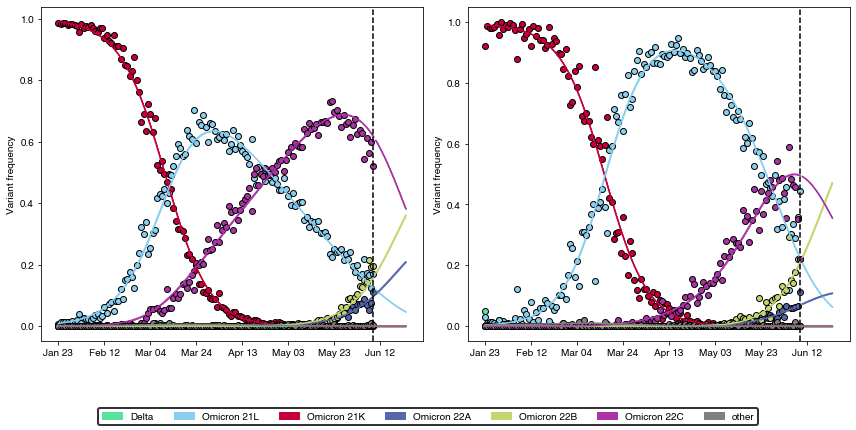

In [19]:
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(nrows=1, ncols=n_groups)

colors = [color_map[v] for v in variant_frequencies.var_names] # Mapping colors to observed variants

for n, name in enumerate(variant_frequencies.names):
    ax = fig.add_subplot(gs[n])

    # Plot predicted frequencies
    plot_MLR_frequencies(ax, X[:,-1, n], freq[...,n], ps, alphas, colors)
    plot_MLR_frequencies(ax, X_forecast[:,-1, n], freq_forecast[...,n], ps, alphas, colors)

    plot_observed_frequency(ax, variant_frequencies.groups[n], colors) # Plot observed frequencies

    ax.axvline(x=len(variant_frequencies.dates)-1, color='k', linestyle='--') # Adding forecast cut off
    add_dates_sep(ax, ef.data.expand_dates(variant_frequencies.dates, forecast_L), sep=20) # Adding dates
    ax.set_ylabel("Variant frequency") # Making ylabel


# Make legend
patches = [matplotlib.patches.Patch(color=c, label=l) for l, c in color_map.items()]
legend = fig.legend(patches, list(color_map.keys()), ncol=len(color_map.keys()), loc="lower center")  
legend.get_frame().set_linewidth(2.)
legend.get_frame().set_edgecolor("k")
fig.tight_layout()
fig.subplots_adjust(bottom = 0.2)

In [23]:
# We will need function get_groups which can return sites for a corresponding group
def get_groups(samples, sites, group):
    samples_group = dict()
    for site in sites:
        samples_group[site] = samples[site][..., group] 
    return samples_group

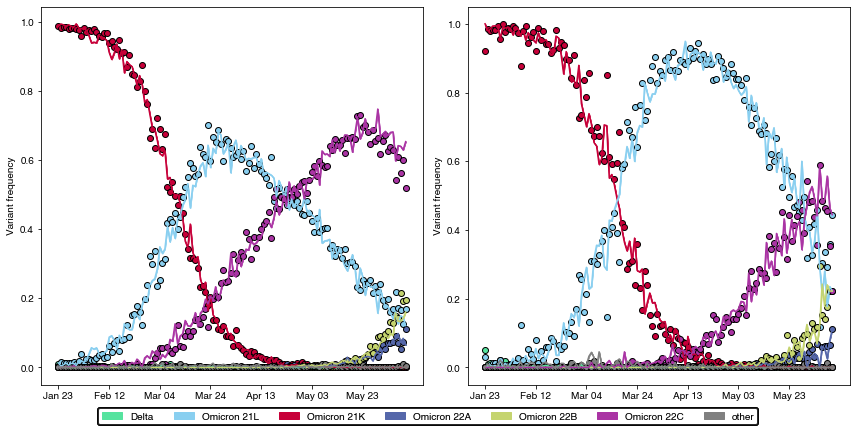

In [24]:
fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(nrows=1, ncols=n_groups)

colors = [color_map[v] for v in variant_frequencies.var_names] # Mapping colors to observed variants

for n, name in enumerate(variant_frequencies.names):
    ax = fig.add_subplot(gs[n])

    # Plot posterior predictive frequency
    dataset = get_groups(posterior.samples, ["seq_counts"], n)     
    plot_ppc_frequency(ax, dataset, variant_frequencies.groups[n], ps, alphas, colors)
    plot_observed_frequency(ax, variant_frequencies.groups[n], colors) # Plot observed frequencies
    add_dates_sep(ax, variant_frequencies.dates, sep=20) # Adding dates
    ax.set_ylabel("Variant frequency") # Making ylabel
    

    # Make legend
    patches = [matplotlib.patches.Patch(color=c, label=l) for l, c in color_map.items()]
    legend = fig.legend(patches, list(color_map.keys()), ncol=len(color_map.keys()), loc="lower center")  
    legend.get_frame().set_linewidth(2.)
    legend.get_frame().set_edgecolor("k")
    fig.tight_layout()
    fig.subplots_adjust(bottom = 0.1)